# Import Data:
Download data files from google drive and read the training and testing data.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1G0HTksv0mfQ7-YPOvlpWDbsGicRaH9ES' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test_data.npy')

# https://drive.google.com/file/d/1jcfzOMqJWmdMBxdPFCvquLOkleZieSBu/view?usp=share_link
file_id = '1jcfzOMqJWmdMBxdPFCvquLOkleZieSBu' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test_label.npy')

# https://drive.google.com/file/d/1xbpY6_CQPPU3SNZGlGqzb6JuWU5WJHkI/view?usp=share_link
file_id = '1xbpY6_CQPPU3SNZGlGqzb6JuWU5WJHkI' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train_data.npy')

# https://drive.google.com/file/d/1UtR68UzRjcYx5oyB1Y08eYj5SWvueCag/view?usp=share_link
file_id = '1UtR68UzRjcYx5oyB1Y08eYj5SWvueCag' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train_label.npy')

# Implication of MLP Model:
This section defines 
- The MLP model
- The standardization and normalization functions used for data preprocessing
- The functions generates confusion matrix and other evluation matrix for the evaluation of model performance.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import time

# Standardization
class StandardScaler: 
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, df):
        self.mean = np.mean(df, axis=0)
        self.std = np.std(df, axis=0)

    def transform(self, df):
        df_scaled = (df - self.mean) / self.std
        return df_scaled

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

# Normalization 
class MinMaxScaler:
    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, df):
        self.min = np.min(df, axis=0)
        self.max = np.max(df, axis=0)

    def transform(self, df):
        df_scaled = (df - self.min) / (self.max - self.min)
        return df_scaled

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

# one-hot encoding
def y_true_convertion(y_true_label):
    y_true = np.zeros([y_true_label.shape[0], 10])
    for i, label in enumerate(y_true_label):
        y_true[i][label[0]] = 1
        
    return y_true

#read in dataset
train_data = np.load("train_data.npy")
train_data_label = np.load("train_label.npy")
test_data = np.load("test_data.npy")
test_data_label = np.load("test_label.npy")

n_samples = train_data.shape[0]
n_features = train_data.shape[1]
n_classes = 10
scaler = StandardScaler()

X_train = scaler.fit_transform(train_data)
y_train = y_true_convertion(train_data_label)

X_test = scaler.fit_transform(test_data)
y_test = y_true_convertion(test_data_label)

# Activation functions
class Activation:
    def __init__(self, activation):
        # Selection fo Activation Function
        if activation == "ReLU":
            self.forward = self.ReLU_forward
            self.backward = self.ReLU_backward
        elif activation == "GELU":
            self.forward = self.GELU_forward
            self.backward = self.GELU_backward

    def ReLU_forward(self, inputs):
        # ReLU Function max(0, x)
        return np.maximum(0, inputs)

    def ReLU_backward(self, inputs):
        # ReLU Function derivative: if x > 0, output = 1, else output = 0
        inputs = inputs > 0 # Convert the elements in the inputs array into True or False based on the boolean comparation
        output = inputs.astype(float) # Then convert the array with True and False into 1 and 0 respectively 
        return output
    
    def GELU_forward(self, inputs):
        # GELU Function: 0.5 * x * (1 + tanh(sqrt(2 / pi) * (x + 0.044715 * x^3)))
        return 0.5 * inputs * (1 + np.tanh(np.sqrt(2 / np.pi) * (inputs + 0.044715 * inputs**3)))

    def GELU_backward(self, inputs):
        # GELU Function derivative
        cdf = 0.5 * (1 + np.tanh(np.sqrt(2 / np.pi) * (inputs + 0.044715 * inputs**3)))
        pdf = 0.5 * np.sqrt(2 / np.pi) * (1 + 0.134145 * inputs**2) * np.exp(-0.5 * inputs**2)
        return cdf + inputs * pdf

# Softmax and cross-entropy loss
class SoftmaxCrossEntropyLoss:
    def forward(self, inputs, target):
        #Softmax Function
        exps = np.exp(inputs)
        probs = exps / np.sum(exps, axis=-1, keepdims=True)
        #Cross Entropy Loss
        sample_num = target.shape[0]
        loss = -np.sum(target * np.log(probs)) / sample_num
        return loss, probs

    def backward(self, inputs, target):
        #Compute the gradient of the softmax and cross-entropy loss
        sample_num = target.shape[0]
        grad = (self.forward(inputs, target)[1] - target) / sample_num
        return grad

# Hidden layer
class Layer:
    def __init__(self, input_size, output_size):
        #Initialize weights with small random value
        self.weights = np.random.uniform(
                low=-np.sqrt(6. / (input_size + output_size)),
                high=np.sqrt(6. / (input_size + output_size)),
                size=(input_size, output_size)
        )
        #Set the size of bias as the size of output dimension
        self.biases = np.zeros((1, output_size))
        self.input = None
        self.grad_weights = None
        self.grad_biases = None

    def forward(self, inputs):
        #Compute the forward output: The sum of (input * network weights) + bias
        self.input = inputs
        return np.dot(self.input, self.weights) + self.biases

    def backward(self, delta):
        #Compute the backward pass: gradients
        self.grad_weights = np.dot(self.input.T, delta)
        self.grad_biases = np.sum(delta, axis=0, keepdims=True)
        return np.dot(delta, self.weights.T)

# Dropout regularization
class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate

    def forward(self, inputs, training):
        if training:
            '''
            Apply dropout to the training input: inputs * mask
            mask <- A binary mask generated by sampling from a Bernoulli distribution 
                    with the probability set to the dropout rate.
            '''
            self.mask = np.random.rand(*inputs.shape) > self.dropout_rate
            return inputs * self.mask
        else:
            #Apply scale to the testing input based on the dropout rate
            return inputs * (1 - self.dropout_rate)

    def backward(self, grad):
        #Apply dropout to the gradients
        return grad * self.mask

# Batch Normalization
class BatchNormalization:
    def __init__(self, input_size, momentum, epsilon=1e-5):
        #A scale parameter
        self.gamma = np.ones((1, input_size))
        #A shift parameter
        self.beta = np.zeros((1, input_size))
        #A hyperparameter controls the contribution of previous gradients
        self.momentum = momentum
        #A small constant added for numerical stability
        self.epsilon = epsilon
        self.imput_norm = None
        self.grad_gamma = None
        self.grad_beta = None

    def forward(self, inputs, training):
        if training:
            #Compute the mean and variance of the activations
            self.batch_mean = np.mean(inputs, axis=0, keepdims=True)
            self.batch_var = np.var(inputs, axis=0, keepdims=True)
        
        #Normalize the activations
        input_norm = (inputs - self.batch_mean) / np.sqrt(self.batch_var + self.epsilon)
        self.input_norm = input_norm
        
        #Apply the learned scale
        return self.gamma * input_norm + self.beta

    def backward(self, grad):
        sample_num = grad.shape[0]
        input_mu = self.input_norm - self.batch_mean #Difference between the inputs and its mean
        std_inv = 1 / np.sqrt(self.batch_var + self.epsilon) #Inverse of the standard deviation based on the variance of the inputs
        d_input_norm = grad * self.gamma #The gradient scaled by gamma
        dvar = np.sum(d_input_norm * input_mu, axis=0) * -.5 * std_inv**3 #The gradient with respect to the batch variance
        dmu = np.sum(d_input_norm * -std_inv, axis=0) + dvar * np.mean(-2 * input_mu, axis=0) #The gradient with respect to the batch mean
        d_input = (d_input_norm * std_inv) + (dvar * 2 * input_mu / sample_num) + (dmu / sample_num)#The gradient with respect to the input 
        self.grad_gamma = np.sum(grad * self.input_norm, axis=0) #Update the gradient with respect to gamma
        self.grad_beta = np.sum(grad, axis=0) #Update the gradient with respect to beta
        return d_input

class MultilayerNeuralNetwork:
    def __init__(self, layer_sizes = [128, 64, 32, 10], dropout_rate=0.5, weight_decay=0.001, momentum=0.9, activation="ReLU", epsilon=1e-5):
        #Initializes the neural network with layers, dropout layers, and batch normalization layers
        self.layers = []
        self.dropout_layers = []
        self.batchnorm_layers = []
        self.activations = []
        for i in range(len(layer_sizes) - 1):
            '''
            Based on the layer sizes create corresponding hidden layers
            Example: layer_sizes = [128,64,32,10] -> layer1:[128,64]; layer2:[64,32]; layer3:[32, 10]
            '''
            self.layers.append(Layer(layer_sizes[i], layer_sizes[i + 1]))
            #Create corresponding batch normalization layer and dropout layer for each layers
            if i < len(layer_sizes) - 2:
                self.batchnorm_layers.append(BatchNormalization(layer_sizes[i + 1], momentum, epsilon))
                self.dropout_layers.append(Dropout(dropout_rate))
        
        self.activation = Activation(activation)
        self.loss = SoftmaxCrossEntropyLoss()
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.v_weights = [np.zeros_like(layer.weights) for layer in self.layers]
        self.v_biases = [np.zeros_like(layer.biases) for layer in self.layers]

    def forward(self, X, training=True):
        x = X.copy()
        #Compute the forward pass through the neural network
        i = 0
        for layer in self.layers:
            x = layer.forward(x)
            if i < len(self.layers) - 1:
                #Apply batch normalization and dropout
                x = self.batchnorm_layers[i].forward(x, training)
                x = self.activation.forward(x)
                x = self.dropout_layers[i].forward(x, training)
            i += 1
        
        return x

    def compute_loss(self, logits, y_true):
        #Compute the Cross Entropy Loss based on the output and the true value
        return self.loss.forward(logits, y_true)

    def backward(self, logits, y_true): 
        #Compute the gradients
        grad = self.loss.backward(logits, y_true)
        for i, layer in reversed(list(enumerate(self.layers))):
            grad = layer.backward(grad)
            if i > 0:
                grad = self.dropout_layers[i - 1].backward(grad)
                grad = self.activation.backward(grad)
                grad = self.batchnorm_layers[i - 1].backward(grad)

    def update_weights(self, learning_rate):
        i = 0
        for layer in self.layers:
            #Update the velocity weights and biases based on the momentum, learning rate and weight decay
            self.v_weights[i] = (self.momentum * self.v_weights[i] +
                                        learning_rate * (layer.grad_weights + self.weight_decay * layer.weights))
            self.v_biases[i] = (self.momentum * self.v_biases[i] +
                                        learning_rate * layer.grad_biases)
            #Update the weights and biases of the layer
            layer.weights -= self.v_weights[i]
            layer.biases -= self.v_biases[i]
            i += 1

    def train(self, X_train, y_train, epochs = 50, batch_size = 100, learning_rate = 0.001):
        train_loss_ls = []
        train_accuracy_ls = []
        test_accuracy_ls = []
        m = X_train.shape[0]
        for epoch in range(epochs):
            #Randomize the allocation of the training data
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]
            for i in range(0, m, batch_size): #Iterates through the dataset with a step size equal to batch_size and i start with 0
                #Mini-Batch training
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                logits = self.forward(X_batch)
                loss, probs = self.compute_loss(logits, y_batch)
                self.backward(logits, y_batch)
                self.update_weights(learning_rate)
                
            logits = self.forward(X_train)

            train_loss, probs = self.compute_loss(logits, y_train)
            train_accuracy = self.evaluate(X_train, y_train)
            test_accuracy = self.evaluate(X_test, y_test)
            train_loss_ls.append(train_loss)
            train_accuracy_ls.append(train_accuracy)
            test_accuracy_ls.append(test_accuracy)
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}, Train accuracy: {train_accuracy * 100:.2f}%, Test accuracy: {test_accuracy * 100:.2f}%')

        return train_loss_ls, train_accuracy_ls, test_accuracy_ls
        
    def predict(self, X):
        logits = self.forward(X, training=False)
        #Softmax Function
        exps = np.exp(logits)
        probs = exps / np.sum(exps, axis=-1, keepdims=True)
        predictions = np.argmax(probs, axis=-1)
        return predictions

    def evaluate(self, X, y_true):
        y_true = np.argmax(y_true, axis=-1)
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y_true)
        return accuracy

# Confusion matrix and other evluation matrix
def confusion_matrix(actual_labels, predicted_labels):
    unique_labels = np.sort(pd.unique(test_data_label.flatten()))
    unique_labels = pd.Index(unique_labels)
    confusion_matrix = pd.DataFrame(0, index=unique_labels, columns=unique_labels)

    # fill in the confusion matrix
    for actual_label, predicted_label in zip(actual_labels, predicted_labels):
        confusion_matrix.loc[actual_label, predicted_label] += 1

    return confusion_matrix

def evaluation_metrics(confusion_matrix):
    metrics = pd.DataFrame(columns=['precision', 'recall', 'f1_score'])

    for label in confusion_matrix.index:
        tp = confusion_matrix.loc[label, label]
        fp = confusion_matrix.loc[:, label].sum() - tp
        fn = confusion_matrix.loc[label, :].sum() - tp

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * precision * recall / (precision + recall)

        metrics.loc[label] = [precision, recall, f1_score]

    return metrics

# Best Model
The final selected model with relatively the best performance. 

In [ ]:
layer_sizes = [n_features, 200, n_classes]  # Input, hidden and output layer sizes
dropout_rate = 0.1
weight_decay = 0
momentum = 0.95
activation = "ReLU" 
epochs = 50
batch_size = 128
learning_rate = 0.001

start_time = time.time()
model = MultilayerNeuralNetwork(layer_sizes, dropout_rate, weight_decay, momentum, activation)
model_best = model.train(X_train, y_train, epochs, batch_size, learning_rate)
end_time = time.time()

print("Time cost: {:.4f} seconds.".format(end_time - start_time))

Epoch 1/50, Loss: 1.7551, Train accuracy: 40.65%, Test accuracy: 39.93%
Epoch 2/50, Loss: 1.7203, Train accuracy: 41.42%, Test accuracy: 40.73%
Epoch 3/50, Loss: 1.7014, Train accuracy: 42.00%, Test accuracy: 41.68%
Epoch 4/50, Loss: 1.6875, Train accuracy: 42.41%, Test accuracy: 42.00%
Epoch 5/50, Loss: 1.6784, Train accuracy: 42.61%, Test accuracy: 42.09%
Epoch 6/50, Loss: 1.6715, Train accuracy: 42.76%, Test accuracy: 42.53%
Epoch 7/50, Loss: 1.6644, Train accuracy: 42.93%, Test accuracy: 42.62%
Epoch 8/50, Loss: 1.6608, Train accuracy: 43.23%, Test accuracy: 42.67%
Epoch 9/50, Loss: 1.6560, Train accuracy: 43.23%, Test accuracy: 42.99%
Epoch 10/50, Loss: 1.6528, Train accuracy: 43.59%, Test accuracy: 43.14%
Epoch 11/50, Loss: 1.6493, Train accuracy: 43.77%, Test accuracy: 43.05%
Epoch 12/50, Loss: 1.6465, Train accuracy: 43.75%, Test accuracy: 43.08%
Epoch 13/50, Loss: 1.6449, Train accuracy: 43.68%, Test accuracy: 43.27%
Epoch 14/50, Loss: 1.6417, Train accuracy: 43.84%, Test accu

# Performance of the Best Model
This section shows the performance of the best model from various directions including Cross Entropy Loss, Train Accuracy, Test Accuracy amound different Epoch and the model's Confusion Matrix and Evaluation matrix.

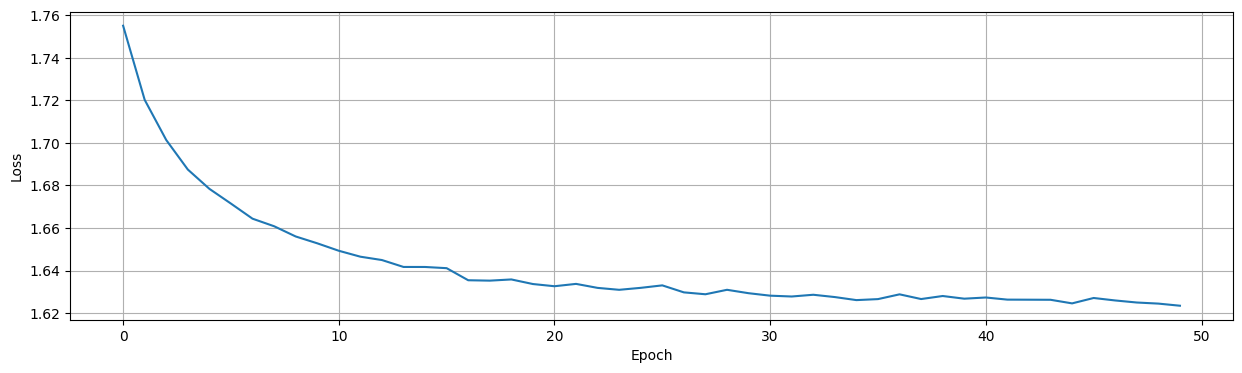

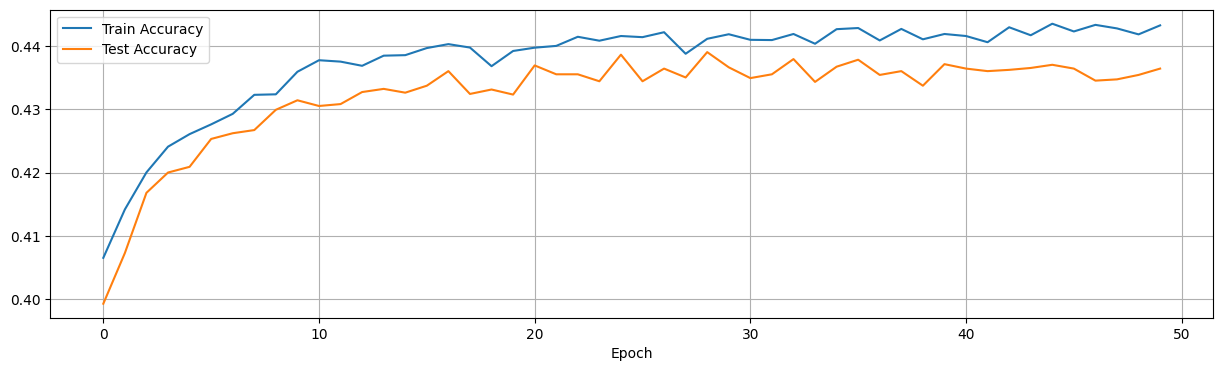

In [ ]:
pl.figure(figsize=(15,4))
pl.plot(model_best[0])
pl.ylabel('Loss')
pl.xlabel('Epoch')
pl.grid()

pl.figure(figsize=(15,4))
pl.plot(model_best[1], label = "Train Accuracy")
pl.plot(model_best[2], label = "Test Accuracy")
pl.xlabel('Epoch')
pl.legend()
pl.grid()

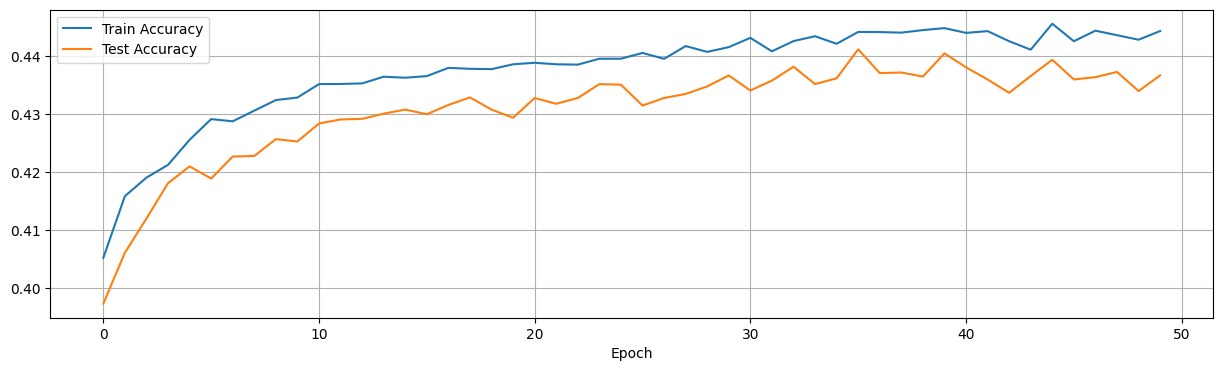

In [ ]:
pl.figure(figsize=(15,4))
pl.plot(model_best[1], label = "Train Accuracy")
pl.plot(model_best[2], label = "Test Accuracy")
pl.xlabel('Epoch')
pl.legend()
pl.grid()

In [ ]:
cm = confusion_matrix(model.predict(X_test), test_data_label)
cm

,0,1,2,3,4,5,6,7,8,9
0,481,40,88,36,50,28,6,41,127,50
1,41,520,38,44,25,36,27,33,66,173
2,62,25,315,96,150,96,70,65,27,19
3,29,27,75,274,45,174,88,53,32,28
4,13,19,113,52,321,63,98,93,13,12
5,24,35,53,150,42,314,47,54,34,23
6,30,45,174,174,191,114,594,68,14,45
7,55,51,81,82,124,101,36,481,31,58
8,188,67,38,41,27,49,15,37,571,99
9,77,171,25,51,25,25,19,75,85,493


In [ ]:
evaluation_metrics(cm)

,precision,recall,f1_score
0,0.467,0.504865,0.485195
1,0.517,0.525941,0.521432
2,0.280,0.347395,0.310078
3,0.277,0.341975,0.306077
4,0.338,0.388060,0.361304
5,0.358,0.380042,0.368692
6,0.561,0.413717,0.476231
7,0.486,0.448339,0.466411
8,0.592,0.500423,0.542373
9,0.491,0.472115,0.481373
